## Popularity-based Recommenders
Aim: to recommend company with new custmers of potentially high spendings in the company 
> By total spending, weighted spending in the company's top areas / categories

### Summary of I/O csv files

Input Files
    > 'area.csv'     - product area code & descripton
    > 'caregory.csv' - product sub-category...
    > 'company_area_percentage.csv'         - percentage revenue for company by product areas
    > 'company_category_percentage.csv'     - ... by product sub-category

Output Files
    > 'popularity_company_36.csv'              - customers recommended based on overall customer spending
    > 'popularity_company_36_area.csv'         - ...on weighted customer spending in the company's top 3 areas
    > 'popularity_company_36_category.csv'     - ...on weighted customer spending in the company's top 10 categoris
    > 'summary_popularity_company_36.csv'           - summary: percentile-mean of actual revenue by recommended customers
    > 'summary_popularity_company_36_area.csv'      - ...
    > 'summary_popularity_company_36_category.csv'  - ...


In [2]:
""" Retriving data from mongodb"""
import pandas as pd
from pymongo import MongoClient

def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """
    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)
    return(conn[db])

def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    cursor = db[collection].find(query)
    df =  pd.DataFrame(list(cursor))
    # Delete the _id
    if no_id:
        del df['_id']
    return(df)

lines_all = read_mongo("BT4221_DB", "Lines")

"""training data only"""
lines = lines_all[lines_all.OrderDate<=20070630]
print(len(lines)) 
lines.sample(1)

29200868


,HH_ID,CompanyID,OrderNum,OrderDate,ProductArea,MajorCategory,Dollars,Quantity,Channel
20548250,999442,795,12186948,20050830,6,40,13,1,C


# 
## Recomender 1: General Popularity of households

> recomend new customers by their total spending in the training period (30 months)

In [3]:
""" Customers with spending in training period (sum all spending)"""
df = lines.groupby(by=["HH_ID"])['Dollars'].sum().to_frame().sort_values(by="Dollars",ascending=False).reset_index()
#file_name = "hh_spending.csv"
#df.to_csv(file_name, index=False) 
df.sample(1)

,HH_ID,Dollars
1707545,1939694,60


In [4]:
""" Customers contributing to company 36's revenue in testing period """
lines_test = lines_all[lines_all.OrderDate>20070630]
company = 36
lines_test = lines_test[lines_test.CompanyID==company].groupby(by=["HH_ID"])['Dollars'].sum().to_frame().sort_values(by="Dollars",ascending=False).reset_index()
lines_test.columns = ["HH_ID","ActualRevenue"]
print(len(lines_test))
lines_test.sample(1)

82328


,HH_ID,ActualRevenue
2831,1196159,251


In [6]:
""" Recomended Customers sorted by worthiness (summed spending in training period)"""
recommended_hh =df[df.HH_ID.isin(list(set(lines.HH_ID)-set(lines[lines.CompanyID==company].HH_ID)))]
test_output  = pd.merge(recommended_hh,lines_test,how='left', on = ["HH_ID"])
test_output["HH_ID"] = test_output["HH_ID"].astype(int).astype('str')
test_output = test_output.fillna(0).sort_values(by="Dollars",ascending=False).reset_index(drop=True)
print(len(test_output))
# Output to csv
output_name = "popularity_company_36.csv"
test_output.to_csv(output_name, index=False)

1950780


In [7]:
""" Summary Statitics, Mean_est_dol refers to worthiness"""
import numpy as np
quant = [0,10,20,30,40,50,60,70,80,90,100]
quant_est = np.percentile(test_output.index,quant)
groups =  test_output.groupby(pd.cut(test_output.index, quant_est, include_lowest=True))
df4 = groups.agg({"HH_ID": 'count', 'Dollars': 'mean', "ActualRevenue":'mean'})
df4["percentile"] = quant[1:]
df4 = df4[["percentile", "HH_ID","Dollars","ActualRevenue"]]
# Output to csv
df4.to_csv("summary_"+output_name, index=False)
measure = "dol"
df4.columns = ['Percentile','HH_Number', 'Mean_est_'+measure, 'Mean_actual_'+measure, ]
df4.loc[:,:]

,Percentile,HH_Number,Mean_est_dol,Mean_actual_dol
"[0, 195077.9]",10,195078,2338.589364,1.131368
"(195077.9, 390155.8]",20,195078,744.505613,0.927655
"(390155.8, 585233.7]",30,195078,449.614329,0.725858
"(585233.7, 780311.6]",40,195078,297.128313,0.639903
"(780311.6, 975389.5]",50,195078,200.951855,0.538923
"(975389.5, 1170467.4]",60,195078,138.062401,0.449220
"(1170467.4, 1365545.3]",70,195078,94.431294,0.405448
"(1365545.3, 1560623.2]",80,195078,62.782400,0.370247
"(1560623.2, 1755701.1]",90,195078,38.815607,0.338603
"(1755701.1, 1950779]",100,195078,18.871697,0.305006


# 
## Recomender 2: Top 3 Area Popularity 

> recomend new customers by their weighted spending in the company's top 3 areas in the training period (30 months)

In [8]:
""" Customers with spending in training period (weighted sum of top-area-spending)"""
import re
import numpy as np
# Pivot by HH_ID and area, dollars
lines.ProductArea = lines.ProductArea.apply(lambda s: s if s<10 else 10) # 10 product areas
df_area = lines.groupby(by=["HH_ID", "ProductArea"])['Dollars'].sum().to_frame().sort_values(by="Dollars",ascending=False).reset_index()
df_area_wide = df_area.pivot(index='HH_ID', columns='ProductArea', values='Dollars')
df_area_wide = df_area_wide.replace(np.nan, 0, regex=True)
# Find company's top n area
perc_name = "company_area_percentage.csv"
perc = pd.read_csv(perc_name)
company = 36
company_perc= perc[perc.CompanyID==company].drop(["CompanyID"], axis =1).iloc[0]
topn = 3
dict_ = company_perc.nlargest(topn).to_dict() # top (name, percentage) pair by percentage
# Rename to true name and Match with Company's top
area = pd.read_csv("area.csv")
df_area_wide.rename(columns=dict(zip(area.Code, area.Description)), inplace=True)
selected_area = df_area_wide[list(dict_.keys())]
# multiply by percentage
for key in list(dict_.keys()):
    selected_area[key] = selected_area[key]*dict_[key]
selected_area["Dollars"] = selected_area.sum(axis=1)
selected_area["HH_ID"] = selected_area.index
selected_area = selected_area[["HH_ID", "Dollars"]].reset_index(drop=True)
print("areas selected: ", dict_)
selected_area.head(2)

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


areas selected:  {'Entertainment': 0.097146353556051779, 'Fashion': 0.070041309490972731, 'Home & Garden': 0.70758843741750277}


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ProductArea,HH_ID,Dollars
0,1,18.771071
1,3,12.117147


In [9]:
""" Recomended Customers sorted by worthiness (weighted sum of top-area-spending in training period)"""
recommended_hh_area =selected_area[selected_area.HH_ID.isin(list(set(lines.HH_ID)-set(lines[lines.CompanyID==company].HH_ID)))]
test_output_area  = pd.merge(recommended_hh_area,lines_test,how='left', on = ["HH_ID"])
test_output_area["HH_ID"] = test_output_area["HH_ID"].astype(int).astype('str')
test_output_area = test_output_area.fillna(0).sort_values(by="Dollars",ascending=False).reset_index(drop=True)
print(len(test_output_area)) # total number of recommended customers
# Output to csv
output_name = "popularity_company_36_area.csv"
test_output_area.to_csv(output_name, index=False)

1950780


In [11]:
""" Summary Statitics, Mean_est_dol refers to worthiness"""
import numpy as np
quant = [0,10,20,30,40,50,60,70,80,90,100]
quant_est = np.percentile(test_output.index,quant)
groups =  test_output_area.groupby(pd.cut(test_output_area.index, quant_est, include_lowest=True))
df4_area = groups.agg({"HH_ID": 'count', 'Dollars': 'mean', "ActualRevenue":'mean'})
df4_area["percentile"] = quant[1:]
df4_area = df4_area[["percentile", "HH_ID","Dollars","ActualRevenue"]]
# Output to csv
df4_area.to_csv("summary_"+output_name, index=False)
measure = "dol"
df4_area.columns = ['Percentile','HH_Number', 'Mean_est_'+measure, 'Mean_actual_'+measure, ]
df4_area.loc[:,:]

,Percentile,HH_Number,Mean_est_dol,Mean_actual_dol
"[0, 195077.9]",10,195078,652.661707,1.202176
"(195077.9, 390155.8]",20,195078,191.758918,0.976732
"(390155.8, 585233.7]",30,195078,97.755830,0.849758
"(585233.7, 780311.6]",40,195078,55.310940,0.659475
"(780311.6, 975389.5]",50,195078,32.270684,0.523703
"(975389.5, 1170467.4]",60,195078,18.811247,0.451102
"(1170467.4, 1365545.3]",70,195078,10.429457,0.342176
"(1365545.3, 1560623.2]",80,195078,5.225394,0.293093
"(1560623.2, 1755701.1]",90,195078,2.101072,0.289489
"(1755701.1, 1950779]",100,195078,0.019317,0.244528


# 
## Recomender 3: Top 10 Category Popularity 

> recomend new customers by their weighted spending in the company's top 10 subcategories in the training period (30 months)

In [12]:
""" Customers with spending in training period (weighted sum of top-category-spending)"""
# Pivot by HH_ID and category, dollars
lines.MajorCategory = lines.MajorCategory.apply(lambda s: s if s<73 else 2) # change 1 and 73 to 2
lines.MajorCategory = lines.MajorCategory.apply(lambda s: s if s>1 else 2) # change 1 and 73 to 2
df_category = lines.groupby(by=["HH_ID", "MajorCategory"])['Dollars'].sum().to_frame().sort_values(by="Dollars",ascending=False).reset_index()
df_category_wide = df_category.pivot(index='HH_ID', columns='MajorCategory', values='Dollars')
df_category_wide = df_category_wide.replace(np.nan, 0, regex=True)
# Find company's top n category
perc_name = "company_category_percentage.csv"
perc = pd.read_csv(perc_name)
company = 36
company_perc= perc[perc.CompanyID==company].drop(["CompanyID"], axis =1).iloc[0]
topn = 10
dict_ = company_perc.nlargest(topn).to_dict() # top (name, percentage) pair by percentage
# Rename to true name and Match with Company's top
category = pd.read_csv("category.csv")
df_category_wide.rename(columns=dict(zip(category.Code, category.Description)), inplace=True)
selected_category = df_category_wide[list(dict_.keys())]
# multiply by percentage
for key in list(dict_.keys()):
    selected_category[key] = selected_category[key]*dict_[key]
selected_category["Dollars"] = selected_category.sum(axis=1)
selected_category["HH_ID"] = selected_category.index
selected_category = selected_category[["HH_ID", "Dollars"]].reset_index(drop=True)
print("categorys selected: ", dict_)
selected_category.head(2)

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

categorys selected:  {"Women's Apparel                   ": 0.048360193878892253, 'Home Decor                     ': 0.17271266909474856, 'Furniture                      ': 0.051784140487157015, 'Toys                              ': 0.048644389244467463, 'Household Items                ': 0.055067056532510913, 'Collectibles                   ': 0.037461684349412161, 'Crafts and Hobbies             ': 0.044141456386426484, 'Garden                         ': 0.06839373331433575, 'Patio & Yard                             ': 0.1006284368552017, 'Wall Decor                        ': 0.041450919927052264}


MajorCategory,HH_ID,Dollars
0,1,12.090048
1,3,8.366314


In [13]:
""" Recomended Customers sorted by worthiness (weighted sum of top-category-spending in training period)"""
recommended_hh_category =selected_category[selected_category.HH_ID.isin(list(set(lines.HH_ID)-set(lines[lines.CompanyID==company].HH_ID)))]
test_output_category  = pd.merge(recommended_hh_category,lines_test,how='left', on = ["HH_ID"])
test_output_category["HH_ID"] = test_output_category["HH_ID"].astype(int).astype('str')
test_output_category = test_output_category.fillna(0).sort_values(by="Dollars",ascending=False).reset_index(drop=True)
print(len(test_output_category)) # total number of recommended customers
# Output to csv
output_name = "popularity_company_36_category.csv"
test_output_category.to_csv(output_name, index=False)

1950780


In [14]:
""" Summary Statitics, Mean_est_dol refers to worthiness"""
import numpy as np
quant = [0,10,20,30,40,50,60,70,80,90,100]
quant_est = np.percentile(test_output.index,quant)
groups =  test_output_category.groupby(pd.cut(test_output_category.index, quant_est, include_lowest=True))
df4_category = groups.agg({"HH_ID": 'count', 'Dollars': 'mean', "ActualRevenue":'mean'})
df4_category["percentile"] = quant[1:]
df4_category = df4_category[["percentile", "HH_ID","Dollars","ActualRevenue"]]
# Output to csv
df4_category.to_csv("summary_"+output_name, index=False)
measure = "dol"
df4_category.columns = ['Percentile','HH_Number', 'Mean_est_'+measure, 'Mean_actual_'+measure, ]
df4_category.loc[:,:]

,Percentile,HH_Number,Mean_est_dol,Mean_actual_dol
"[0, 195077.9]",10,195078,81.851451,1.170014
"(195077.9, 390155.8]",20,195078,22.833590,0.862634
"(390155.8, 585233.7]",30,195078,12.152169,0.774880
"(585233.7, 780311.6]",40,195078,7.008429,0.647592
"(780311.6, 975389.5]",50,195078,4.055805,0.541189
"(975389.5, 1170467.4]",60,195078,2.149604,0.462389
"(1170467.4, 1365545.3]",70,195078,0.759162,0.407345
"(1365545.3, 1560623.2]",80,195078,0.000000,0.294636
"(1560623.2, 1755701.1]",90,195078,0.000000,0.341612
"(1755701.1, 1950779]",100,195078,0.000000,0.329940


#### Plot accumulative average dollars vs number of potential customer recommeded


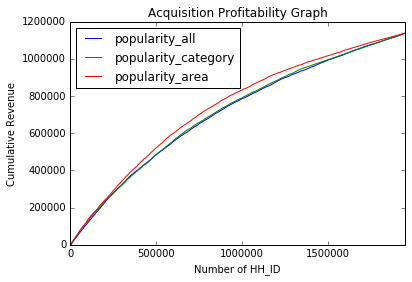

In [6]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

list_ = []
score_names = ["36","36_category","36_area"]
for score_name in score_names:
    file_name = "popularity_company_"+ score_name + ".csv"
    predictions = pd.read_csv(file_name)
    predictions =  predictions.join(predictions.groupby('Dollars')['ActualRevenue'].mean(), on='Dollars', rsuffix='Mean')    
    # (Actual Revenue Mean) CumSum
    score_name = score_name.replace("36","popularity") if score_name!="36" else "popularity_all"
    predictions[score_name] = predictions.ActualRevenueMean.cumsum()
    list_.append(predictions[score_name])
plt.figure()
graph = pd.concat(list_, axis=1) ## (Actual Revenue Mean) CumSum
graph.plot(title='Acquisition Profitability Graph')
plt.xlabel('Number of HH_ID')
plt.ylabel('Cumulative Revenue')
plt.savefig("popularity_acquisition_profitability_curve.jpeg")